In [1]:
import numpy as np
import pandas as pd
from math import isclose
from matplotlib import pyplot as plt
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from typing import Union, List

In [2]:
def write_to_submission_file(predicted_probs, out_file: str = 'to_submission.csv.zip',
                             target='target', index_label='session_id'):
    df = pd.DataFrame(predicted_probs,
                      index = np.arange(1, len(predicted_probs) + 1),
                      columns=[target])
    df.to_csv(out_file, index_label=index_label, compression="zip")

In [3]:
"""Define all type transformations in a single function"""
def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    sites = [s for s in df.columns if "site" in s]
    df[sites] = df[sites].fillna(0).astype('uint16')
    times = [t for t in df.columns if "time" in t]
    df[times] = df[times].apply(pd.to_datetime)
    if 'target' in df.columns:
        df['target'] = df.target.astype('uint8')
    return df

In [4]:
import os
# os.getcwd()
# os.listdir("../../../../")

train_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv.zip')
train_df = convert_types(train_df)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv.zip')
test_df = convert_types(test_df)

In [5]:
sites = [s for s in train_df.columns if 'site' in s]
times = [t for t in train_df.columns if 'time' in t]

In [6]:
# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [7]:
%%time
sites_corpus = full_df[sites].to_string(header=False, index=False).split('\n')

Wall time: 14.2 s


In [8]:
%%time
tfv = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train = tfv.fit_transform(sites_corpus[:idx_split])
X_test = tfv.transform(sites_corpus[idx_split:])

X_full = vstack([X_train, X_test]).tocsr()
X_full

Wall time: 10.8 s


<336358x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 3251875 stored elements in Compressed Sparse Row format>

In [9]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)

def get_auc_logit_score(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, random_state=17, solver='liblinear')
    cv_scores = cross_val_score(logit, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

In [10]:
%%time
BASELINE = get_auc_logit_score(X_train, y_train)
print(f"{BASELINE:.4f}")

0.8692
Wall time: 9.55 s


In [11]:
# Features engineering
feat_df = pd.DataFrame(index=full_df.index)

In [12]:
# Add the new feature to the sparse matrix
def add_feature(feat: str, f_df: pd.DataFrame = feat_df, X_sparse = X_full, standardize=True, onehot=False):
    tmp = f_df[[feat]].values
    if onehot:
        enc = OneHotEncoder(dtype=np.uint8, sparse=False)
        tmp = enc.fit_transform(tmp)
    if standardize:
        tmp = StandardScaler().fit_transform(tmp)        
    return hstack([X_sparse, tmp]).tocsr()

In [13]:
def add_multi_feature(feat_list: list, f_df: pd.DataFrame = feat_df, X_sparse = X_full):
    X_new = X_sparse
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    return X_new[:idx_split, :], X_new[idx_split:, :]     

In [14]:
def test_feature(feat: str, standardize=True, onehot=False, baseline=BASELINE, C=1):
    print(f"Testing:\t{feat}")
        
    X_new = add_feature(feat, standardize=standardize, onehot=onehot)
    X_train = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train, y_train, C=C)
    
    print(f"Score:\t\t{score:.4f}\t", end="")
    if score > baseline:
        print("+++")
    else:
        print("---")
    return score

In [15]:
def test_multi_feature(feat_list: list, baseline=BASELINE, C=1):    
    print(f"Testing:\t{feat_list}")
    
    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    X_train = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train, y_train, C=C)
    
    print(f"Score:\t\t{score:.4f}\t", end="")
    if score > baseline:
        print("+++")
    else:
        print("---")
    return score
    

In [16]:
def predict_probs(feat_list: list, C=1):
    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    X_train = X_new[:idx_split, :]
    X_test = X_new[idx_split:, :]
    estimator = LogisticRegression(C=C, random_state=17, solver='liblinear')
    estimator.fit(X_train, y_train)
    return estimator.predict_proba(X_test)[:, 1]

In [17]:
# previous features
for weekday in range(7):
    feat_name = f'weekday_{weekday}'
    feat_df[feat_name] = (full_df['time1'].dt.weekday == weekday).astype(int)
for hour in range(23):
    feat_name = f'hour_{hour}'
    feat_df[feat_name] = (full_df['time1'].dt.hour == hour).astype(int)
best_hours = ['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22']
best_weekdays = ['weekday_0']
best_previous = best_hours + best_weekdays

In [18]:
# feat_df['duration'] = full_

feat_df['duration'] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)).dt.total_seconds()

In [19]:
test_feature('duration')

Testing:	duration
Score:		0.8699	+++


0.8698902967308999

In [20]:
%%time
# feat_df['n_unique'] = full_df[times].nunique(axis=1, dropna=True)

Wall time: 0 ns


In [21]:
# test_feature('n_unique')

In [22]:
# time between requests
deltas = ['delta' + str(i) for i in range(1, 10)]
delta_df = (full_df[times] - full_df[times].shift(1, axis=1)) \
                                        .copy() \
                                        .drop(columns='time1') \
                                        .apply(lambda x: x.dt.total_seconds())

delta_df.columns = deltas

delta_target = delta_df[:idx_split].loc[y_train == 1]
delta_rest = delta_df[:idx_split].loc[y_train == 0]

delta_df.head()

,delta1,delta2,delta3,delta4,delta5,delta6,delta7,delta8,delta9
21668,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54842,0.0,1784.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
77291,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
114020,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
146669,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


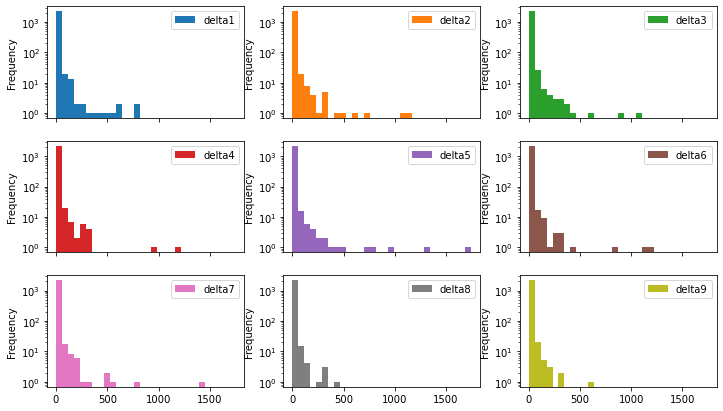

In [23]:
delta_target.plot(kind='hist',                  
                   bins=30,
                   subplots=True, 
                   layout=(3,3), 
                   figsize=(12, 7), 
                   logy=True)
plt.show()

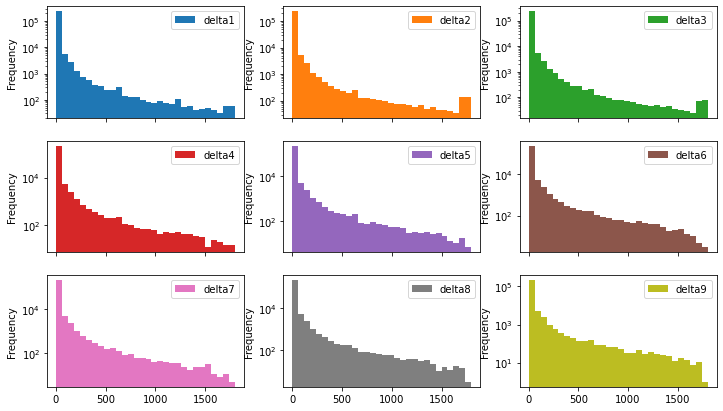

In [24]:
delta_rest.plot(kind='hist', 
               subplots=True,
               bins=30,
               layout=(3,3), 
               figsize=(12, 7), 
               logy=True)
plt.show()

In [ ]:
delta_target['delta1']

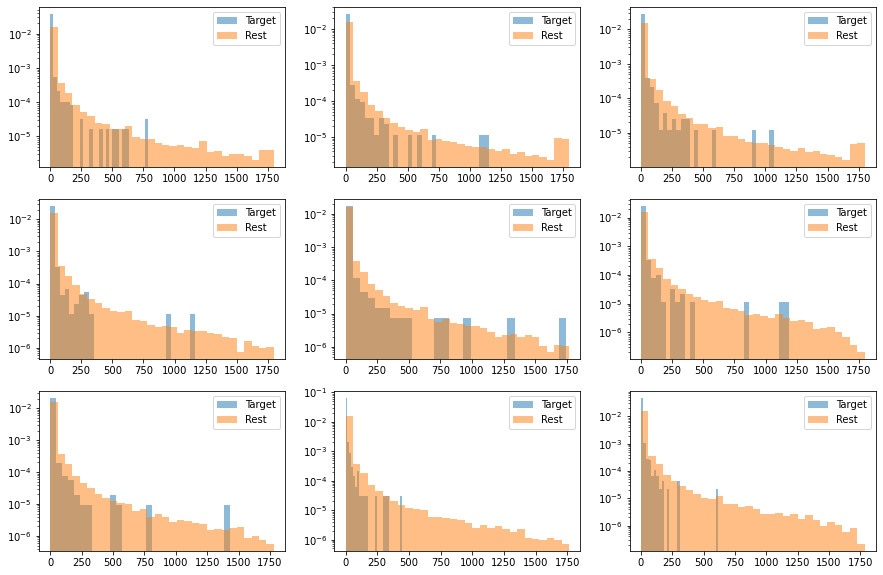

In [56]:
fig = plt.figure(figsize=(15,10))
for i, feat in enumerate(deltas):
    plt.subplot(3, 3, i+1)
    plt.hist(delta_target[feat], bins=30, alpha=0.5, label="Target", density=True)
    plt.hist(delta_rest[feat], bins=30, alpha=0.5, label="Rest", density=True)
    plt.yscale('log')
    plt.legend()    

In [25]:
tree = DecisionTreeClassifier(max_depth = 1)
threshhold = {}
for feat in deltas:
#     feat_name = 'delta1'
    X_train = delta_df[:idx_split][[feat]].fillna(0)
    score = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc').mean()
    tree.fit(X_train, y_train)
    print(f"{feat}: {score:.4f} {tree.tree_.threshold[0]}")
    threshhold[feat] = tree.tree_.threshold[0]    

delta1: 0.5416 7.5
delta2: 0.5327 11.5
delta3: 0.5373 7.5
delta4: 0.5372 9.5
delta5: 0.5311 21.5
delta6: 0.5341 5.5
delta7: 0.5310 13.5
delta8: 0.5399 8.5
delta9: 0.5279 29.5


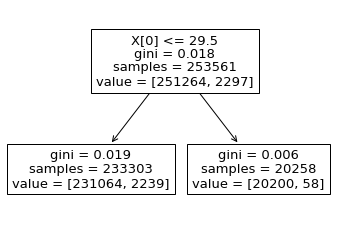

In [27]:
plot_tree(tree)
plt.show()

In [37]:
# new features after decision tree found the relevant thresholds
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > threshhold[feat]).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8677	---
Testing:	delta2
Score:		0.8667	---
Testing:	delta3
Score:		0.8648	---
Testing:	delta4
Score:		0.8679	---
Testing:	delta5
Score:		0.8692	---
Testing:	delta6
Score:		0.8678	---
Testing:	delta7
Score:		0.8695	+++
Testing:	delta8
Score:		0.8675	---
Testing:	delta9
Score:		0.8692	---


In [38]:
# new features after decision tree found the relevant thresholds
for feat in deltas:
    feat_df[feat] = (delta_df[feat] < threshhold[feat]).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8670	---
Testing:	delta2
Score:		0.8661	---
Testing:	delta3
Score:		0.8638	---
Testing:	delta4
Score:		0.8667	---
Testing:	delta5
Score:		0.8669	---
Testing:	delta6
Score:		0.8665	---
Testing:	delta7
Score:		0.8682	---
Testing:	delta8
Score:		0.8666	---
Testing:	delta9
Score:		0.8679	---


In [39]:
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > 400).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8690	---
Testing:	delta2
Score:		0.8691	---
Testing:	delta3
Score:		0.8693	+++
Testing:	delta4
Score:		0.8689	---
Testing:	delta5
Score:		0.8693	+++
Testing:	delta6
Score:		0.8692	---
Testing:	delta7
Score:		0.8693	+++
Testing:	delta8
Score:		0.8690	---
Testing:	delta9
Score:		0.8689	---


In [42]:
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > 100).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8685	---
Testing:	delta2
Score:		0.8683	---
Testing:	delta3
Score:		0.8696	+++
Testing:	delta4
Score:		0.8693	+++
Testing:	delta5
Score:		0.8692	---
Testing:	delta6
Score:		0.8694	+++
Testing:	delta7
Score:		0.8688	---
Testing:	delta8
Score:		0.8695	+++
Testing:	delta9
Score:		0.8697	+++


In [41]:
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > 50).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8680	---
Testing:	delta2
Score:		0.8684	---
Testing:	delta3
Score:		0.8689	---
Testing:	delta4
Score:		0.8694	+++
Testing:	delta5
Score:		0.8695	+++
Testing:	delta6
Score:		0.8694	+++
Testing:	delta7
Score:		0.8691	---
Testing:	delta8
Score:		0.8697	+++
Testing:	delta9
Score:		0.8691	---


In [44]:
# new features after decision tree found the relevant thresholds
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > threshhold[feat] * 10).astype(int)
    test_feature(feat)

Testing:	delta1
Score:		0.8685	---
Testing:	delta2
Score:		0.8689	---
Testing:	delta3
Score:		0.8694	+++
Testing:	delta4
Score:		0.8693	+++
Testing:	delta5
Score:		0.8692	---
Testing:	delta6
Score:		0.8694	+++
Testing:	delta7
Score:		0.8689	---
Testing:	delta8
Score:		0.8695	+++
Testing:	delta9
Score:		0.8682	---


In [45]:
best_delta = []
for feat in deltas:
    feat_df[feat] = (delta_df[feat] > 100).astype(int)
    if test_feature(feat) > BASELINE:
        best_delta.append(feat)

Testing:	delta1
Score:		0.8685	---
Testing:	delta2
Score:		0.8683	---
Testing:	delta3
Score:		0.8696	+++
Testing:	delta4
Score:		0.8693	+++
Testing:	delta5
Score:		0.8692	---
Testing:	delta6
Score:		0.8694	+++
Testing:	delta7
Score:		0.8688	---
Testing:	delta8
Score:		0.8695	+++
Testing:	delta9
Score:		0.8697	+++


In [47]:
test_multi_feature(best_delta)

Testing:	['delta3', 'delta4', 'delta6', 'delta8', 'delta9']
Score:		0.8701	+++


In [51]:
test_multi_feature(best_delta + ['duration'])

Testing:	['delta3', 'delta4', 'delta6', 'delta8', 'delta9', 'duration']
Score:		0.8696	+++


In [52]:
test_multi_feature(['duration'])

Testing:	['duration']
Score:		0.8699	+++


In [50]:
test_multi_feature(best_previous)

Testing:	['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'weekday_0']
Score:		0.9193	+++


In [53]:
test_multi_feature(best_previous + best_delta)

Testing:	['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'weekday_0', 'delta3', 'delta4', 'delta6', 'delta8', 'delta9']
Score:		0.9203	+++


In [54]:
test_multi_feature(best_previous + best_delta + ['duration'])

Testing:	['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'weekday_0', 'delta3', 'delta4', 'delta6', 'delta8', 'delta9', 'duration']
Score:		0.9203	+++


In [55]:
write_to_submission_file(predict_probs(best_previous + best_delta), out_file='logit_subm11.csv.zip')

In [28]:
### Optimize regularization for best set of features
"""
c_values = np.logspace(0, 2, 10)
logit_grid_searcher = GridSearchCV(estimator=logit,
                                   param_grid={'C': c_values},
                                   scoring='roc_auc',
                                   cv=time_split,
                                   n_jobs=-1,
                                   verbose=1)
"""                                   

"\nc_values = np.logspace(0, 2, 10)\nlogit_grid_searcher = GridSearchCV(estimator=logit,\n                                   param_grid={'C': c_values},\n                                   scoring='roc_auc',\n                                   cv=time_split,\n                                   n_jobs=-1,\n                                   verbose=1)\n"

In [29]:
# X_train_new, X_test_new = add_multi_feature()

In [30]:
# logit_grid_searcher.fit(X_train_new, y_train)

In [31]:
# logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [32]:
# logit_test_probs = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
# write_to_submission_file(logit_test_probs, 'logit_subm11.csv.zip')